In [0]:
!pip install tensorflow-gpu==1.9.0
!pip install tensorflow==1.9.0

     |████████████████████████████████| 229.6MB 65kB/s 
     |████████████████████████████████| 3.3MB 45.6MB/s 
     |████████████████████████████████| 573kB 53.5MB/s 
ERROR: xarray 0.15.1 has requirement setuptools>=41.2, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.9.0 which is incompatible.
ERROR: google-auth 1.7.2 has requirement setuptools>=40.3.0, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: setuptools 47.1.1
    Uninstalling setuptools-47.1.1:
      Successfully uninstalled setuptools-47.1.1


     |████████████████████████████████| 51.1MB 60kB/s 
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


In [0]:
import torch
print(torch.__version__)

1.5.0+cu101


In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import sys
import random
from collections import defaultdict
import heapq
import math
import argparse
import tqdm

In [0]:
"""
BPR loss under matrix factorization model
pair-wise model
"""

def load_data():
    '''
    As for bpr experiment, all ratings are removed.
    '''
    data_path = "/content/drive/My Drive/python_code/thesis_recommendation_1m/processed/processed_data_100.csv"
    data_df = pd.read_csv(data_path, encoding='utf-8')
    user_ratings = defaultdict(set)
    max_u_id = -1
    max_i_id = -1

    for index, row in data_df.iterrows():
        u = int(row['user'])
        i = int(row['movie'])
        user_ratings[u].add(i)
        max_u_id = max(u, max_u_id)
        max_i_id = max(i, max_i_id)
    return max_u_id, max_i_id, user_ratings

# def load_data():
#     '''
#     As for bpr experiment, all ratings are removed.
#     '''
#     data_path = "/content/drive/My Drive/python_code/data/processed_ratings.dat"
#     user_ratings = defaultdict(set)
#     max_u_id = -1
#     max_i_id = -1
#     with open(data_path, 'r') as f:
#         for line in f:
#             linetuple = line.strip().split("::")
#             u = int(linetuple[0])
#             i = int(linetuple[1])
#             user_ratings[u].add(i)
#             max_u_id = max(u, max_u_id)
#             max_i_id = max(i, max_i_id)

#     return max_u_id, max_i_id, user_ratings


def generate_test(user_ratings):
    '''
    for each user, random select one of his(her) rating into test set
    leave one out
    '''
    user_test = dict()
    for u, i_set in user_ratings.items():
        user_test[u] = random.sample(i_set, 1)[0]
    return user_test


def generate_train_batch(user_ratings, user_ratings_test, item_count, batch_size):
    '''
    uniform sampling (user, item_rated, item_not_rated)
    '''
    t = []
    for b in range(batch_size):
        u = random.sample(user_ratings.keys(), 1)[0]
        i = random.sample(user_ratings[u], 1)[0]
        while i == user_ratings_test[u]:
            i = random.sample(user_ratings[u], 1)[0]

        j = random.randint(1, item_count)
        while j in user_ratings[u]:
            j = random.randint(1, item_count)
        t.append([u, i, j])

    return np.array(t)


def generate_test_batch(user_ratings, user_ratings_test, item_count):
    '''
    for an user u and an item i rated by u,
    generate pairs (u,i,j) for all subsampled item j which u has not rated
    it's convinent for computing AUC score for u
    '''
    for u in user_ratings.keys():
        t = []
        negative_item_list = []
        i = user_ratings_test[u]
        # print("user_ratings_test", user_ratings_test[1])
        cnt = 0
        while cnt < 100:
            j = random.choice(range(1, item_count + 1))
            if j not in negative_item_list and j not in user_ratings[u]:
                t.append([u, i, j])
                negative_item_list.append(j)
                cnt += 1

        yield np.array(t), [u, i, negative_item_list]


"""
compute HR@10 and NDCG@10 for one user
"""
def eval_one_rating(user_mat, item_mat, item_bias, u, i, j_list, isShowList, k=10):

    map_item_score = {}
    map_item_score[i] = np.dot(user_mat[u], item_mat[i]) + item_bias[i]
    for j in j_list:
        map_item_score[j] = np.dot(user_mat[u], item_mat[j]) + item_bias[j]

    rank_list = heapq.nlargest(k, map_item_score, key = map_item_score.get)


    hr = getHitRate(rank_list, i)
    ndcg = getNDCG(rank_list, i)

    if isShowList and k == 10:
          users.append(u)
          movies.append(rank_list)
          # print(rank_list)
    return [hr, ndcg]


def getHitRate(rank_list, purchased_item):
    if purchased_item in rank_list:
        return 1
    return 0


# normalized discounted cumulative gain (NDCG)
def getNDCG(rank_list, purchased_item):
    if purchased_item in rank_list:
        ranked_idx = rank_list.index(purchased_item)
        return float(1) / (math.log(ranked_idx + 2, 2))
    return 0


def bpr_mf(user_count, item_count, hidden_dim, regulation_rate, learning_rate):

    u = tf.placeholder(tf.int32, [None])
    i = tf.placeholder(tf.int32, [None])
    j = tf.placeholder(tf.int32, [None])

    user_emb_w = tf.Variable(tf.random_normal([user_count+1, hidden_dim], stddev = 0.1),
                             name = "user_emb_w")
    item_emb_w = tf.Variable(tf.random_normal([item_count+1, hidden_dim], stddev = 0.1),
                             name = "item_emb_w")
    item_b = tf.Variable(tf.zeros([item_count+1]), name = "item_b")

    u_emb = tf.nn.embedding_lookup(user_emb_w, u)
    i_emb = tf.nn.embedding_lookup(item_emb_w, i)
    i_b = tf.nn.embedding_lookup(item_b, i)
    j_emb = tf.nn.embedding_lookup(item_emb_w, j)
    j_b = tf.nn.embedding_lookup(item_b, j)

    # MF predict: u_i > u_j
    x = i_b - j_b + tf.reduce_sum(tf.multiply(u_emb, (i_emb - j_emb)), 1)

    # AUC for one user:
    # reasonable iff all (u,i,j) pairs are from the same user
    # average AUC = mean( auc for each user in test set)
    #mf_auc = tf.reduce_mean(tf.to_float(x > 0))
    correct_pred = tf.greater(x, 0)
    mf_auc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    l2_norm = tf.add_n([
            tf.reduce_sum(tf.multiply(u_emb, u_emb)),
            tf.reduce_sum(tf.multiply(i_emb, i_emb)),
            tf.reduce_sum(tf.multiply(j_emb, j_emb))
        ])

    #regulation_rate = 0.0001
    bprloss = regulation_rate * l2_norm - tf.reduce_mean(tf.log(tf.sigmoid(x)))
    y = tf.reduce_sum(tf.multiply(u_emb, i_emb), 1) + i_b
    train_op = tf.train.AdagradOptimizer(learning_rate).minimize(bprloss)

    return u, i, j, mf_auc, bprloss, train_op, user_emb_w, item_emb_w, item_b


def run_bpr(user_count, item_count, user_ratings, user_ratings_test,
            hidden_dim, regulation_rate, learning_rate, batch_size):

    with tf.Session() as session:

        u, i, j, mf_auc, bprloss, train_op, user_emb_w, item_emb_w, item_b = \
                bpr_mf(user_count, item_count, hidden_dim, regulation_rate, learning_rate)

        session.run(tf.global_variables_initializer())
        epoch_range = 100
        for epoch in tqdm.tqdm(range(1, epoch_range)):
            _batch_bprloss = 0
            for k in range(1, 5000): # uniform samples from training set
                uij = generate_train_batch(user_ratings, user_ratings_test, item_count, batch_size)

                _bprloss, train_opt = session.run([bprloss, train_op],
                                          feed_dict={u:uij[:,0], i:uij[:,1], j:uij[:,2]})

                _batch_bprloss += _bprloss

            bpr_loss = _batch_bprloss / k
            
            # print ("epoch: ", epoch)
            # print ("bpr_loss: ", bpr_loss)

            epoch_list.append(epoch)
            bpr_loss_list.append(bpr_loss)


            _auc_sum = 0.0

            _hr_sum_1 = 0.0
            _ndcg_sum_1 = 0.0
            _hr_sum_2 = 0.0
            _ndcg_sum_2 = 0.0
            _hr_sum_3 = 0.0
            _ndcg_sum_3 = 0.0
            _hr_sum_4 = 0.0
            _ndcg_sum_4 = 0.0
            _hr_sum_5 = 0.0
            _ndcg_sum_5 = 0.0
            _hr_sum_6 = 0.0
            _ndcg_sum_6 = 0.0 
            _hr_sum_7 = 0.0
            _ndcg_sum_7 = 0.0  
            _hr_sum_8 = 0.0
            _ndcg_sum_8 = 0.0   
            _hr_sum_9 = 0.0
            _ndcg_sum_9 = 0.0
            _hr_sum_10 = 0.0
            _ndcg_sum_10 = 0.0      

            # each batch will return only one user's auc, hit rate, and ndcg
            user_mat, item_mat, item_bias = session.run([user_emb_w, item_emb_w, item_b])
            for t_uij, uij_list in generate_test_batch(user_ratings, user_ratings_test, item_count):

                _auc = session.run(mf_auc, feed_dict={u:t_uij[:,0], i:t_uij[:,1], j:t_uij[:,2]})
                _auc_sum += _auc

                isShowList = epoch == (epoch_range-1)
                # print(isShowList)

                if isShowList:
                  _hr1, _ndcg1 = eval_one_rating(user_mat, item_mat, item_bias, uij_list[0], uij_list[1], uij_list[2], isShowList, 1)
                  _hr_sum_1 += _hr1
                  _ndcg_sum_1 += _ndcg1

                  _hr2, _ndcg2 = eval_one_rating(user_mat, item_mat, item_bias, uij_list[0], uij_list[1], uij_list[2], isShowList, 2)
                  _hr_sum_2 += _hr2
                  _ndcg_sum_2 += _ndcg2

                  _hr3, _ndcg3 = eval_one_rating(user_mat, item_mat, item_bias, uij_list[0], uij_list[1], uij_list[2], isShowList, 3)
                  _hr_sum_3 += _hr3
                  _ndcg_sum_3 += _ndcg3

                  _hr4, _ndcg4 = eval_one_rating(user_mat, item_mat, item_bias, uij_list[0], uij_list[1], uij_list[2], isShowList, 3)
                  _hr_sum_4 += _hr4
                  _ndcg_sum_4 += _ndcg4

                  _hr5, _ndcg5 = eval_one_rating(user_mat, item_mat, item_bias, uij_list[0], uij_list[1], uij_list[2], isShowList, 5)
                  _hr_sum_5 += _hr5
                  _ndcg_sum_5 += _ndcg5

                  _hr6, _ndcg6 = eval_one_rating(user_mat, item_mat, item_bias, uij_list[0], uij_list[1], uij_list[2], isShowList, 6)
                  _hr_sum_6 += _hr6
                  _ndcg_sum_6 += _ndcg6

                  _hr7, _ndcg7 = eval_one_rating(user_mat, item_mat, item_bias, uij_list[0], uij_list[1], uij_list[2], isShowList, 7)
                  _hr_sum_7 += _hr7
                  _ndcg_sum_7 += _ndcg7

                  _hr8, _ndcg8 = eval_one_rating(user_mat, item_mat, item_bias, uij_list[0], uij_list[1], uij_list[2], isShowList, 8)
                  _hr_sum_8 += _hr8
                  _ndcg_sum_8 += _ndcg8

                  _hr9, _ndcg9 = eval_one_rating(user_mat, item_mat, item_bias, uij_list[0], uij_list[1], uij_list[2], isShowList, 9)
                  _hr_sum_9 += _hr9
                  _ndcg_sum_9 += _ndcg9

  
                _hr10, _ndcg10 = eval_one_rating(user_mat, item_mat, item_bias, uij_list[0], uij_list[1], uij_list[2], isShowList, 10)
                _hr_sum_10 += _hr10
                _ndcg_sum_10 += _ndcg10

            test_auc = _auc_sum/user_count

            if isShowList:
              test_hr_1 = _hr_sum_1 / user_count
              test_ndcg_1 = _ndcg_sum_1 / user_count

              test_hr_2 = _hr_sum_2 / user_count
              test_ndcg_2 = _ndcg_sum_2 / user_count

              test_hr_3 = _hr_sum_3 / user_count
              test_ndcg_3 = _ndcg_sum_3 / user_count

              test_hr_4 = _hr_sum_4 / user_count
              test_ndcg_4 = _ndcg_sum_4 / user_count

              test_hr_5 = _hr_sum_5 / user_count
              test_ndcg_5 = _ndcg_sum_5 / user_count

              test_hr_6 = _hr_sum_6 / user_count
              test_ndcg_6 = _ndcg_sum_6 / user_count

              test_hr_7 = _hr_sum_7 / user_count
              test_ndcg_7 = _ndcg_sum_7 / user_count

              test_hr_8 = _hr_sum_8 / user_count
              test_ndcg_8 = _ndcg_sum_8 / user_count

              test_hr_9 = _hr_sum_9 / user_count
              test_ndcg_9 = _ndcg_sum_9 / user_count

            test_hr_10 = _hr_sum_10 / user_count
            test_ndcg_10 = _ndcg_sum_10 / user_count

            if isShowList:
              print ("test_auc: ", test_auc)
              print ('text_hr 1', test_hr_1)
              print ("test_ndcg 1: ", test_ndcg_1)

              print ('text_hr 2', test_hr_2)
              print ("test_ndcg 2: ", test_ndcg_2)

              print ('text_hr 3', test_hr_3)
              print ("test_ndcg 3: ", test_ndcg_3)

              print ('text_hr 4', test_hr_4)
              print ("test_ndcg 4: ", test_ndcg_4)

              print ('text_hr 5', test_hr_5)
              print ("test_ndcg 5: ", test_ndcg_5)

              print ('text_hr 6', test_hr_6)
              print ("test_ndcg 6: ", test_ndcg_6)

              print ('text_hr 7', test_hr_7)
              print ("test_ndcg 7: ", test_ndcg_7)
            
              print ('text_hr 8', test_hr_8)
              print ("test_ndcg 8: ", test_ndcg_8)

              print ('text_hr 9', test_hr_9)
              print ("test_ndcg 9: ", test_ndcg_9)

              print ("test_hr 10: ", test_hr_10)
              print ("test_ndcg 10: ", test_ndcg_10)
            

            auc_list.append(test_auc)
            hr_list.append(test_hr_10)
            ndcg_list.append(test_ndcg_10)
            
      

# def get_prediction(user_ratings):




def parse_args():
    """
    parse the embedding model arguments
    """
    parser_arg = argparse.ArgumentParser(description =
                                        "Bayesian Personalized Ranking for top-N recommendation system")
    parser_arg.add_argument('hidden_dim', type = int, default = 20,
                            help = 'number of dimension in BPR')
    parser_arg.add_argument('regulation_rate', type = float, default = 0.0001,
                            help = 'matrix regularization parameter')
    parser_arg.add_argument('learning_rate', type = float, default = 0.01,
                            help = 'learning rate during min-batch gradient descent')
    parser_arg.add_argument('batch_size', type = int, default = 50,
                            help = 'min-batch size')
    return parser_arg.parse_args()


In [0]:
user_count, item_count, user_ratings = load_data()

In [0]:
bpr_loss_list = []
auc_list = []
hr_list = []
ndcg_list = []
epoch_list = []

users = []
movies = []

run_bpr(user_count, item_count, user_ratings, user_ratings_test,
            32, 0.001, 0.01, 1)

# run_bpr(user_count, item_count, user_ratings, user_ratings_test,
#             hidden_dim, regulation_rate, learning_rate, batch_size):





  0%|          | 0/99 [00:00<?, ?it/s]



  1%|          | 1/99 [00:08<14:18,  8.76s/it]



  2%|▏         | 2/99 [00:17<14:09,  8.76s/it]



  3%|▎         | 3/99 [00:26<13:57,  8.73s/it]



  4%|▍         | 4/99 [00:34<13:47,  8.71s/it]



  5%|▌         | 5/99 [00:43<13:35,  8.68s/it]



  6%|▌         | 6/99 [00:51<13:22,  8.63s/it]



  7%|▋         | 7/99 [01:00<13:14,  8.64s/it]



  8%|▊         | 8/99 [01:09<13:04,  8.63s/it]



  9%|▉         | 9/99 [01:17<12:58,  8.65s/it]



 10%|█         | 10/99 [01:26<12:47,  8.62s/it]



 11%|█         | 11/99 [01:34<12:35,  8.59s/it]



 12%|█▏        | 12/99 [01:43<12:26,  8.58s/it]



 13%|█▎        | 13/99 [01:52<12:24,  8.66s/it]



 14%|█▍        | 14/99 [02:00<12:11,  8.61s/it]



 15%|█▌        | 15/99 [02:09<12:01,  8.59s/it]



 16%|█▌        | 16/99 [02:18<11:54,  8.61s/it]



 17%|█▋        | 17/99 [02:26<11:45,  8.60s/it]



 18%|█▊        | 18/99 [02:35<11:35,  8.58s/it]



 19%|█▉        | 19/99 [02:43<11:28,  8.61s/i

test_auc:  0.9786920565951442
text_hr 1 0.5700331125827814
test_ndcg 1:  0.5700331125827814
text_hr 2 0.7119205298013245
test_ndcg 2:  0.6595541057633599
text_hr 3 0.7971854304635762
test_ndcg 3:  0.7021865560944873
text_hr 4 0.7971854304635762
test_ndcg 4:  0.7021865560944873
text_hr 5 0.8841059602649006
test_ndcg 5:  0.7381700731177867
text_hr 6 0.9109271523178808
test_ndcg 6:  0.7477239744938629
text_hr 7 0.9269867549668874
test_ndcg 7:  0.753077175376866
text_hr 8 0.938907284768212
test_ndcg 8:  0.7568376838418629
text_hr 9 0.9461920529801324
test_ndcg 9:  0.759030617585111
test_hr 10:  0.9521523178807947
test_ndcg 10:  0.7607535205234296


In [0]:
print(len(users))
print(len(movies))

import numpy as np
np.save('/content/drive/My Drive/python_code/bpr_output/user.npy', users)
np.save('/content/drive/My Drive/python_code/bpr_output/movies.npy', movies)

6040
6040


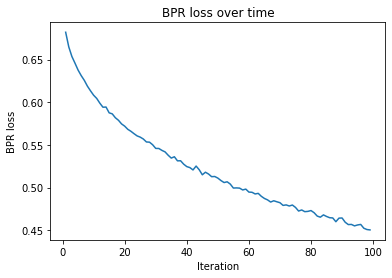

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(epoch_list, bpr_loss_list)
ax.set_ylabel('BPR loss')
ax.set_xlabel('Iteration')
ax.set_title('BPR loss over time')
fig.savefig('/content/drive/My Drive/python_code/thesis_recommendation_1m/figure/BPR_loss_1m_100.png', dpi=300)

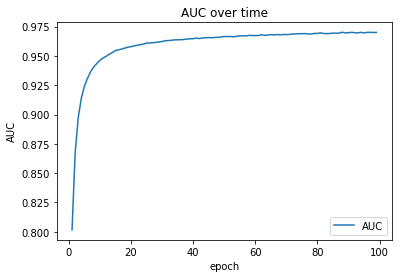

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(epoch_list, auc_list, label='AUC')
ax.set_ylabel('AUC')
ax.set_xlabel('epoch')
ax.set_title('AUC over time')
ax.legend(loc="lower right")
fig.savefig('/content/drive/My Drive/python_code/thesis_recommendation_1m/figure/BPR_loss_1m_100_auc.png', dpi=300)

In [0]:
hr_list_h = [hr-0.2 for hr in hr_list]
print(hr_list_h)

[0.22632450331125825, 0.4094370860927152, 0.528476821192053, 0.5902317880794701, 0.6274834437086092, 0.6602649006622516, 0.6746688741721854, 0.6894039735099338, 0.6981788079470199, 0.7051324503311258, 0.7117549668874172, 0.7182119205298012, 0.7221854304635762, 0.7251655629139073, 0.7274834437086093, 0.7309602649006623, 0.7311258278145696, 0.734271523178808, 0.7336092715231788, 0.7362582781456954, 0.7346026490066224, 0.7365894039735099, 0.7394039735099338, 0.73841059602649, 0.7403973509933774, 0.7427152317880794, 0.7438741721854305, 0.7432119205298013, 0.7432119205298013, 0.7432119205298013, 0.7415562913907285, 0.7443708609271522, 0.7453642384105961, 0.7438741721854305, 0.7451986754966888, 0.7443708609271522, 0.7463576158940397, 0.7453642384105961, 0.7455298013245033, 0.74817880794702, 0.7483443708609272, 0.7488410596026489, 0.7504966887417219, 0.7465231788079469, 0.74817880794702, 0.7485099337748344, 0.7480132450331125, 0.7483443708609272, 0.74817880794702, 0.7504966887417219, 0.749668

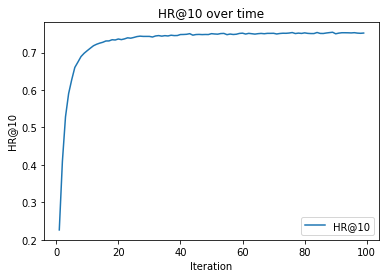

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(epoch_list, hr_list_h, label='HR@10')
ax.set_ylabel('HR@10')
ax.set_xlabel('Iteration')
ax.set_title('HR@10 over time')
ax.legend(loc="lower right")
fig.savefig('/content/drive/My Drive/python_code/thesis_recommendation_1m/figure/BPR_loss_1m_100_hr_20.png', dpi=300)

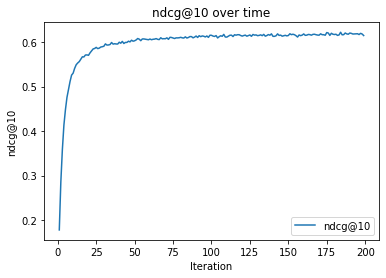

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(epoch_list, ndcg_list, label='ndcg@10')
ax.set_ylabel('ndcg@10')
ax.set_xlabel('Iteration')
ax.set_title('ndcg@10 over time')
ax.legend(loc="lower right")
fig.savefig('/content/drive/My Drive/python_code/thesis_recommendation_1m/figure/BPR_loss_1m_200_ndcg.png', dpi=300)

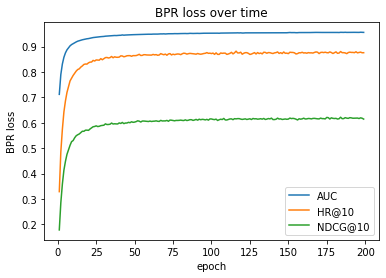

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# ax.plot(epoch_list, bpr_loss_list, label = "BPR loss")

ax.plot(epoch_list, auc_list, label = "AUC")

ax.plot(epoch_list, hr_list, label = "HR@10")

ax.plot(epoch_list, ndcg_list, label = "NDCG@10")


ax.set_ylabel('BPR loss')
ax.set_xlabel('epoch')
ax.set_title('BPR loss over time')
ax.legend()
fig.savefig('/content/drive/My Drive/python_code/thesis_recommendation/figure/BPR_loss_1m_100_no_all.png')

In [0]:
# x1 = [10,20,30]
# y1 = [20,40,10]
# # plotting the line 1 points 
# plt.plot(x1, y1, label = "line 1")

In [0]:
# bpr_loss_list = []
# auc_list = []
# hr_list = []
# ndcg_list = []
# epoch_list = []